Restarted aspire (Python 3.8.18)

In [47]:
import aspire
import numpy as np
import pandas as pd
from aspire.operators import RadialCTFFilter
from aspire.source.simulation import Simulation
from aspire.volume import LegacyVolume, Volume
from utils import volsCovarEigenvec
import time
from covar_estimation import im_stack_backward
import torch
# Specify parameters
img_size = 15  # image size in square
num_imgs = 2000  # number of images
dtype = np.float32


rank = 4
c = rank + 1
vols = LegacyVolume(
    L=img_size,
    C=c,
    dtype=dtype,
).generate()
vols -= np.mean(vols,axis=0)
sim = Simulation(
    #unique_filters=[RadialCTFFilter(defocus=d) for d in np.linspace(1.5e4, 2.5e4, 7)],
    n=num_imgs,
    vols=vols,
    dtype=dtype,
    amplitudes=1,
    offsets = 0
)

vectorsGD = torch.tensor(volsCovarEigenvec(vols),requires_grad = False)

2024-03-27 15:00:37,970 INFO [aspire.source.image] Creating Simulation with 2000 images.


In [48]:
%load_ext autoreload
%autoreload 2

from covar_sgd import CovarDataset,Covar,CovarTrainer,dataset_collate
cds = CovarDataset(sim,vectorsGD = vectorsGD)
covar = Covar(resolution=img_size,rank=rank)#,vectors=vectorsGD)
batch_size = 32
learning_rate = 1e-4*8
momentum = 0.9
reg = 1e-5
gamma_lr = 0.8
gamma_reg = 1
device = torch.device('cuda:0')
dataloader = torch.utils.data.DataLoader(cds,batch_size = batch_size,shuffle = False)#,collate_fn=dataset_collate)
trainer = CovarTrainer(covar,dataloader,device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:

from covar_distributed import trainParallel
import torch.multiprocessing as mp

world_size = torch.cuda.device_count()
kwargs_dict = {'max_epochs' : 10, 'lr' : learning_rate,'momentum' : momentum,'optim_type' : 'SGD','reg' : reg,'gamma_lr': gamma_lr,'gamma_reg' : gamma_reg}
savepath = 'data/tmp2/abc.pk'
trainParallel(covar,cds,batch_size = batch_size,savepath = savepath,**kwargs_dict)



Epoch 0 , cost value : 3.53e+04,  cosine sim : 0.64, frobenium norm error : 7.18e-01: 100%|██████████| 63/63 [00:01<00:00, 40.07it/s]
Epoch 1 , cost value : 2.64e+04,  cosine sim : 0.76, frobenium norm error : 5.96e-01: 100%|██████████| 63/63 [00:01<00:00, 50.84it/s]
Epoch 2 , cost value : 3.39e+04,  cosine sim : 0.83, frobenium norm error : 5.77e-01: 100%|██████████| 63/63 [00:01<00:00, 52.13it/s]
Epoch 3 , cost value : 3.14e+04,  cosine sim : 0.84, frobenium norm error : 5.43e-01: 100%|██████████| 63/63 [00:01<00:00, 51.19it/s]
Epoch 4 , cost value : 3.12e+04,  cosine sim : 0.85, frobenium norm error : 5.53e-01: 100%|██████████| 63/63 [00:01<00:00, 54.49it/s]
Epoch 5 , cost value : 2.99e+04,  cosine sim : 0.85, frobenium norm error : 5.56e-01: 100%|██████████| 63/63 [00:01<00:00, 51.56it/s]
Epoch 6 , cost value : 2.73e+04,  cosine sim : 0.86, frobenium norm error : 5.54e-01: 100%|██████████| 63/63 [00:01<00:00, 51.26it/s]
Epoch 7 , cost value : 3.15e+04,  cosine sim : 0.86, frobenium

In [51]:
trainer.train(**kwargs_dict)

Epoch 0 , cost value : 3.67e+04,  cosine sim : 0.72, frobenium norm error : 8.67e-01: 100%|██████████| 63/63 [00:03<00:00, 18.53it/s]
Epoch 1 , cost value : 3.57e+04,  cosine sim : 0.76, frobenium norm error : 7.59e-01: 100%|██████████| 63/63 [00:03<00:00, 18.98it/s]
Epoch 2 , cost value : 3.22e+04,  cosine sim : 0.80, frobenium norm error : 7.64e-01: 100%|██████████| 63/63 [00:03<00:00, 18.97it/s]
Epoch 3 , cost value : 3.20e+04,  cosine sim : 0.82, frobenium norm error : 7.30e-01: 100%|██████████| 63/63 [00:03<00:00, 18.67it/s]
Epoch 4 , cost value : 3.15e+04,  cosine sim : 0.83, frobenium norm error : 6.63e-01: 100%|██████████| 63/63 [00:03<00:00, 17.09it/s]
Epoch 5 , cost value : 3.09e+04,  cosine sim : 0.84, frobenium norm error : 6.31e-01: 100%|██████████| 63/63 [00:03<00:00, 18.60it/s]
Epoch 6 , cost value : 3.04e+04,  cosine sim : 0.85, frobenium norm error : 6.12e-01: 100%|██████████| 63/63 [00:03<00:00, 19.26it/s]
Epoch 7 , cost value : 3.14e+04,  cosine sim : 0.85, frobenium

KeyboardInterrupt: 

Epoch 8 , cost value : 3.44e+04,  cosine sim : 0.86, frobenium norm error : 5.79e-01:  35%|███▍      | 22/63 [00:16<00:02, 19.94it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: xlabel='Epochs', ylabel='Frobenium norm error'>

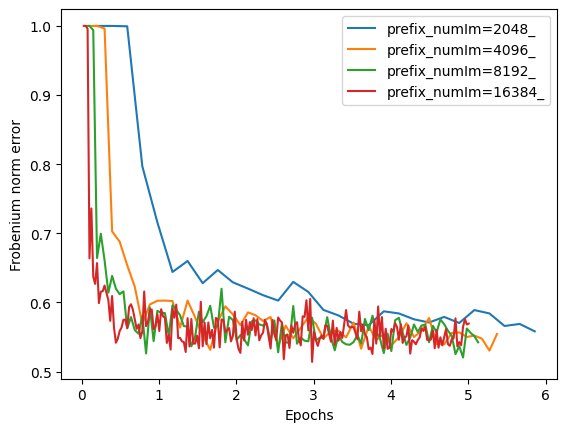

In [52]:
%load_ext autoreload
%autoreload 2
from covar_analyzer import CovarAnalyzer
import torch
c = CovarAnalyzer.load('data/tmp2/results.csv')

#c.plotCosineSim()
#c.plotWeightedCosineSim()
c.plotFroErr()


